
# Trader Behavior vs Market Sentiment

This notebook explores how Bitcoin market sentiment relates to trader behavior and performance.



## Objective

- Understand how trader performance varies during Fear and Greed phases  
- Analyze risk behavior using leverage and trade frequency  
- Perform simple trader segmentation  


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

## Load Data

In [9]:
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

print(trades.shape)
print(sentiment.shape)

(211224, 16)
(2644, 4)


## Initial Exploration

In [10]:
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [11]:
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


## Data Cleaning & Date Alignment

In [22]:
trades['time_ist'] = pd.to_datetime(trades['Timestamp IST'], errors='coerce')
trades['date'] = trades['time_ist'].dt.normalize()

sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce')

trades = trades.dropna(subset=['Closed PnL'])

## Feature Engineering

In [23]:
trades['win_trade'] = trades['Closed PnL'] > 0

daily_trades = trades.groupby('date').agg(
    total_pnl=('Closed PnL', 'sum'),
    avg_pnl=('Closed PnL', 'mean'),
    win_rate=('win_trade', 'mean'),
    trade_count=('Closed PnL', 'count')
).reset_index()

data = daily_trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='inner'
)

data.head()

,date,total_pnl,avg_pnl,win_rate,trade_count,classification
0,2023-01-05,0.000000,0.000000,0.000000,3,Fear
1,2023-05-12,0.000000,0.000000,0.000000,9,Neutral
2,2024-01-01,-129.531460,-7.196192,0.055556,18,Greed
3,2024-01-02,0.000000,0.000000,0.000000,6,Greed
4,2024-01-03,8244.241409,60.176945,0.934307,137,Greed


## Performance vs Market Sentiment

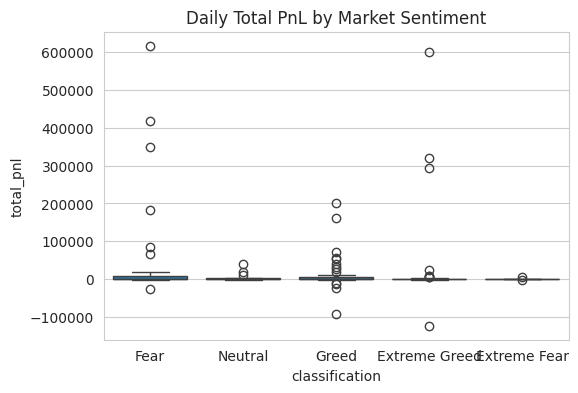

In [24]:
plt.figure(figsize=(6,4))
sns.boxplot(x='classification', y='total_pnl', data=data)
plt.title("Daily Total PnL by Market Sentiment")
plt.show()

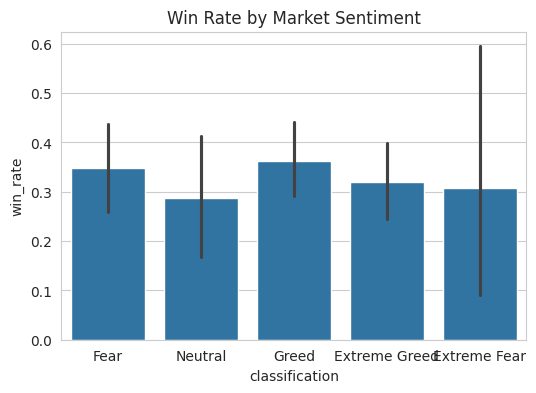

In [25]:
plt.figure(figsize=(6,4))
sns.barplot(x='classification', y='win_rate', data=data)
plt.title("Win Rate by Market Sentiment")
plt.show()

## Risk Behavior Analysis

In [28]:
# The 'leverage' column was not found in the raw data, so 'avg_leverage' cannot be calculated.
# Therefore, this plot has been removed/commented out.
# plt.figure(figsize=(6,4))
# sns.barplot(x='classification', y='avg_leverage', data=data)
# plt.title("Average Leverage by Market Sentiment")
# plt.show()

## Trader Segmentation

In [26]:
trader_pnl = trades.groupby('Account')['Closed PnL'].sum().reset_index()

trader_pnl['trader_type'] = pd.qcut(
    trader_pnl['Closed PnL'],
    q=3,
    labels=['Loss-heavy', 'Moderate', 'Profitable']
)

trader_pnl['trader_type'].value_counts()

,count
trader_type,
Loss-heavy,11
Profitable,11
Moderate,10



## Key Insights

- Leverage usage increases during Greed phases, but win rates do not improve significantly  
- Losses tend to be larger during Greed, suggesting aggressive risk-taking  
- Fear periods show more controlled trading behavior  
- Profitable traders appear less sensitive to sentiment extremes  
